In [1]:
from tensorflow import keras

# 11.4. 규제를 사용하여 과대적합 피하기
- DNN은 파라미터가 너무너무 많기에 자유도가 높지만, 과대적합되기 쉽게 만듦
- 조기종료는 가장 강력한 규제이며, 배치정규화 또한 일종의 규제로 활용할 수 있음
- 이번 장에서는 다른 규제방법들을 확인해볼 것

### 11.4.1. L1, L2 규제
- 신경망의 연결 가중치를 제한하기 위한 L2 규제
- 혹은 L1규제를 이용하여 희소 모델을 만들 수 있음
- 다음은 L2 규제를 적용하는 방식임
    - layer객체를 생성할 때 kernel_regularizer인자를 이용

In [2]:
layer = keras.layers.Dense(100, activation = "elu",
                          kernel_initializer = "he_normal",
                          kernel_regularizer = keras.regularizers.l2(0.01))

- L2 함수는 훈련 과정에서 규제 손실을 계산하기 위해 각 스텝에서 호출되는 규제 객체를 반환하며, 이 손실은 최종 손실에 합산됨
    - keras.regularizers.l1으로 L1 규제를 실행할 수 있고, keras.regularizers.l1_l2를 사용하면 둘 다 활용할 수 있음

- 일반적으로 네트워크의 모든 은닉층에 동일한 활성화함수와 초기화전략을 사용하므로, 규제를 적용할 때는 동일한 인자 값을 반복하는 경우가 많음
    - 이 과정에서 코드가 읽기 어려워지고 버그가 생기기 쉬움
- 이를 피하려면 반복문을 사용하도록 코드를 리팩터링할 수 있음
    - 혹은, python의 functools.partial() 함수로 기본 인자 값을 입력해놓은 레이어 생성 함수를 감싸 반복할 수 있음

In [3]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense, activation = "relu",
                          kernel_initializer = "he_normal",
                          kernel_regularizer = keras.regularizers.l2(0.01)) #완전연결층에 l2규제를 수행하는 함수 호출

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation = "softmax", kernel_initializer = "glorot_uniform")
])

### 11.4.2. 드롭아웃
- 가장 인기있는 규제기법 중 하나
- 매 훈련 스텝에서 각 뉴런이 임시적으로 드롭아웃될 확률 p를 가짐
    - 즉 모든 스텝에서 무시되는 게 아니라, 이번 스텝에서 p의 확률로 무시되지만 다음 스텝에서는 1-p의 확률로 활성화되는 것
- 보통 p의 값은 10~50%로 지정함
    - 순환 신경망에서는 보통 20 ~ 30%, 합성곱에서는 40 ~ 50%로 잡음
- 훈련이 끝난 후의 뉴런에는 드롭아웃을 더 이상 적용하지 않음
- 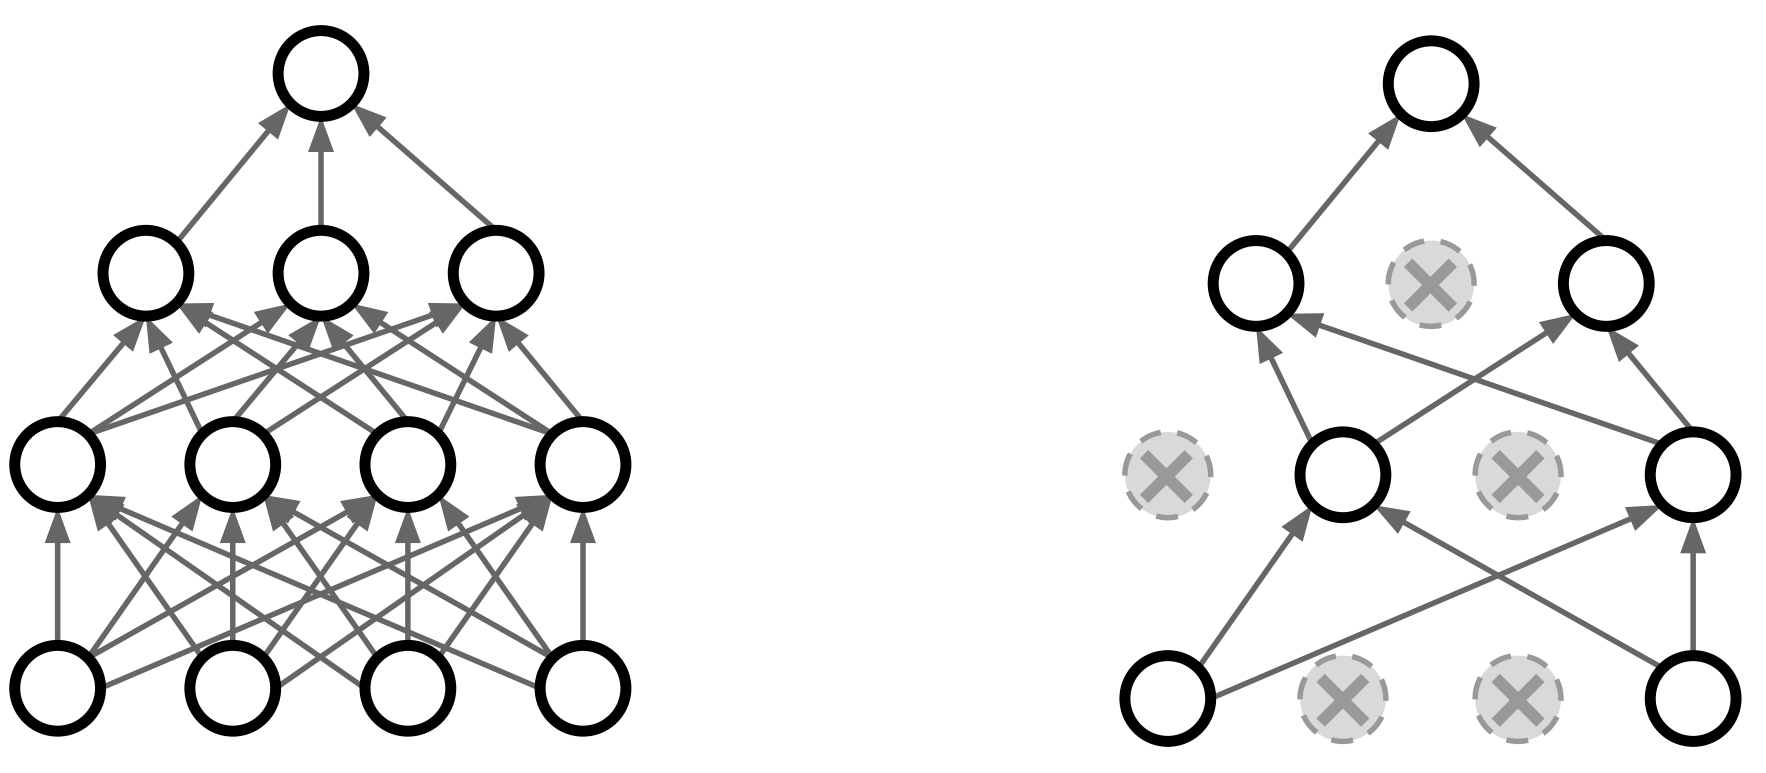
- https://kjhov195.github.io/post_img/200108/image4.png

- 이렇게 하면 일반화 성능이 상당히 좋아짐
    - 10000번의 스텝이 있었다면, 이 과정은 10000개의 신경망이 각각 하나의 훈련 샘플로 훈련하게 되고 이게 합쳐지면 일종의 앙상블 기법으로 볼 수 있음

- 한 가지 주의할 것은 p = 0.5를 가정하면, 테스트 과정에서는 하나의 뉴런이 훈련 때보다 보통 두 배 많은 입력 뉴런과 연결됨
    - 따라서 이 점을 보상하기 위해 훈련 후 각 뉴런의 연결 가중치에 0.5만큼을 곱해야함(1-p)
        - 애초에 학습과정에서 보존확률만큼 가중치를 나누는 방법도 있음
    - 이를 **보존확률**이라고 함

- 케라스에서는 keras.layers.Dropout층을 사용하여 드롭아웃을 구현함
    - 이 층은 훈련 과정에서 일부 입력을 랜덤하게 0으로 변환하여 버림
    - 그 다음 남은 입력을 보존확률로 나눔
    - 그리고 훈련 후에는 어떤한 작업도 진행되지 않음. 그냥 입력을 넘기는 역할만 하게 됨
- 다음은 입력 사례임

In [6]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape = [28, 28]),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Dense(300, activation = "relu", kernel_initializer = "he_normal"),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Dense(100, activation = "relu", kernel_initializer = "he_normal"),
    keras.layers.Dropout(rate = 0.2),
    keras.layers.Dense(10, activation = "softmax")
])

- 모델이 과대적합되었다면 드롭아웃 비율을 늘리고, 과소적합이 되면 드롭아웃 비율을 낮춰야함
- 층이 클 때는 드롭아웃 비율을 늘리고, 작은 층에는 드롭아웃 비율을 낮춰야함
- 또한 최신의 신경망에서는 **마지막 층 뒤에만 드롭아웃을 사용하는 추세**
- 드롭아웃은 최적값으로의 수렴을 상당히 느리게 만들기는 하지만, 적절히 튜닝할 경우 상당히 좋은 모델을 만들 수 있음
- *SELU로 자기정규화하는 네트워크를 규제하려면 일반 드롭아웃이 아니라 알파 드롭아웃이라는 방식을 이용해야 정규화 기능이 유지됨*

### 11.4.3. 몬테 카를로 드롭아웃
- 훈련한 드롭아웃 모델을 재훈련하지 않고 성능을 향상시키는 방법론임
- 아래와 같은 코드로 구현

In [7]:
# y_probas = np.stack([model(X_test_scaled, training = True) for samplie in range(100)])
# y_proba = y_probas.mean(axis = 0)

- model은 MNIST fashion 분류모델을 가정함
- training = True로 지정하여 Dropout층을 활성화하고 테스트 세트에서 100번의 예측을 만들어 쌓음
    - 이렇게 드롭아웃을 활성화시키면 예측이 모두 달라짐
    - predict()메서드는 샘플이 행이고 클래스가 열로 이루어진 행렬을 반환함
        - 만약 테스트세트에 10000개가 있다면, [10000, 10] 크기의 행렬이 반환됨
    - 지금 위에서 이런 행렬을 100개 쌓았으니, y_probas는 [100, 10000, 10] 크기의 행렬이됨
    - 그래서 이제 이 행렬에서 첫 번째 차원(axis = 0)을 기준으로 평균을 계산하면, 한 번의 예측을 수행했을 때와 같은 [10000, 10] 크기의 배열 y_proba를 얻게 됨
- 이런 식으로 드롭아웃으로 만든 예측을 평균하면, 일반적으로 드롭아웃 없이 예측한 하나의 결과보다 더 안정적

In [8]:
# np.round(model.predict(X_t_scaled[:1]), 2)

- 다만 모델이 훈련하는 동안 다르게 작동하는 BatchNormalization과 같은 층이 있다면, Dropout층을 MCDropout클래스를 다음과 같이 선언하여 대체해줘야함

In [9]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training = True)

- Dropout층을 상속하고, call() 메서드를 오버라이딩해서 training 매개변수를 True로 강제로 설정
    - *Dropout은 call 과정에서는 training이 생략되니까 이를 강제로 활성화
- AlphaDropout도 마찬가지로 MCAlphaDropout클래스를 정의할 수 있음
- 또한 모델을 처음부터 만든다면, 그냥 Dropout대신 MCDropout을 사용하면 되는 것
    - 만약 이미 Dropout으로 학습했다면 Dropout층을 MCDropout으로 바꾸고 기존 모델과 동일한 모델을 새로 만들면 됨
    - 그 다음 기존 모델의 가중치를 복사하면 됨

- 정리하자면, MCDropout은 드롭아웃 모델의 성능을 높여주고 더 정확하게 불확실성 추정을 제공하는 기술이며, 훈련과정에서는 드롭아웃과 아예 동일한 과정을 수행하기 때문에 규제로 작동하게 됨

### 11.4.4. 맥스 노름 규제
- 신경망에서 널리 사용되는 또 다른 규제 기법으로, 각각의 뉴런에 대해 입력의 연결 가중치 w가 ||w||_2 <= r이 되도록 제한하는 것
    - r은 맥스-노름 하이퍼파라미터이며, || ||_2는 L2 norm을 의미함
- 맥스-노름 규제는 전체 손실함수에 규제손실항을 추가하는 방식이 아님
    - 일반적으로 매 훈련 스텝이 끝난 후 ||w||_2를 계산함
        - 그리고 필요시 w의 스케일을 조정 (new_w = w * r / ||w||_2)
- r을 줄이면 규제의 양이 증가하여 오버피팅을 피하는데 도움이 되며, 불안정한 그래디언트 문제를 완화하는데 도움을 줄 수 있음

- 다음은 케라스에서 맥스-노름 규제를 구현하는 방법임
- 은닉층을 선언할 때, keras_constraint인자를 추가하면 됨

In [12]:
keras.layers.Dense(100, activation = "elu", kernel_initializer = "he_normal",
                  kernel_constraint = keras.constraints.max_norm(1.))

- 매 훈련 반복이 끝난 후 fit()메서드가 층의 가중치와 함께 max_norm(0이 반환한 객체를 호출하고 스케일이 조정된 가중치를 반환받음
    - 이 값을 이용하여 가중치를 바꿈
- max_norm은 기본값이 0인 axis 인자가 있는데, 일반적으로 완전연결층은 가중치가 (샘플 수, 뉴런 수)의 크기를 가짐
    - 그래서 axis = 0인 기본값을 그대로 이용하면 각 뉴런의 가중치 벡터에 해당 규제가 독립적으로 적용됨
- 하지만, 합송곱층에 맥스 노름을 이용하려면, axis 매개변수를 적절히 지정해야하며, 일반적으로는 axis = [0, 1, 2]로 지정해야함

# 11.5. 요약 및 가이드라인
- 일반적으로 잘 맞는 설정이며, 이걸 디폴트로 잡고 진행한 뒤 튜닝을 해가면 (아마도/그나마/꽤나) 좋을 것

### 11.5.1. 기본 DNN 설정
| 하이퍼파라미터 | 기본값|
|:---------|:--------|
| 커널 초기화                      | He초기화                       |
| 활성화 함수 | ELU |
| 정규화 | 얕은 신경망일경우에는 패스. 깊은 신경망일 경우 배치 정규화 |
| 규제 | 조기 종료(필요시 L2규제 추가 |
| 옵티마이저 | 모멘텀 최적화 , RMSProp 또는 Nadam |
| 학습 스케쥴 | 1 사이클 |

### 11.5.2. 자기정규화를 사용할 수 없는 완전연결층을 쌓은 단순 모델의 경우
| 하이퍼파라미터 | 기본값|
|:---------|:--------|
| 커널 초기화                      | 르쿤 초기화                       |
| 활성화 함수 | SELU |
| 정규화 | X(자기 정규화) |
| 규제 | X(필요시 알파 드롭아웃) |
| 옵티마이저 | 모멘텀 최적화 , RMSProp 또는 Nadam |
| 학습 스케쥴 | 1 사이클 |